In [1]:
# standard libraries
from time import perf_counter_ns
import time

In [2]:
# external libraries
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

# custom libraries
from _run_constants import *
from part_00_file_db_utils import *
from part_00_process_functions import *

In [3]:
word_df, wg_df, letter_dict, char_matrix, \
    word_group_id_list, word_id_list, wchar_matrix = load_input_data(
        db_path=rc.DB_PATH, db_name=rc.DB_NAME,
        in_file_path=rc.IN_FILE_PATH)

...loading words into a dataframe...
...query execution took: 0.47 seconds...
...loading word groups into a dataframe...
...query execution took: 0.46 seconds...
...loading the letter dictionary...
...loading the char matrix...
...subsetting the char matrix...


In [4]:
# load the total number of anagrams
n_possible_anagrams = load_possible_anagrams(db_path=rc.DB_PATH,
                                             db_name=rc.DB_NAME)

...query execution took: 0.0 seconds...


In [5]:
# let's split the matrix, gather the values for each split, and then combine
n_subset_letters = 3
wg_df["letter_selector"] = wg_df["letter_group_ranked"].str[:n_subset_letters]

letter_selector_list = wg_df["letter_selector"].unique()
letter_selector_list.sort()
letter_selector_id_dict = {ls: i_ls for i_ls, ls in enumerate(letter_selector_list)}

wg_df["letter_selector_id"] = wg_df["letter_selector"].map(letter_selector_id_dict)
# here's the thing: I need to be able to identify on a single matrix the rows that match various conditions.
# I can't step through it and create objects at abandon. 
# so, given our wchar_matrix: what are the rows that match to such and such?
# we can add three columns to track this... 

In [9]:
wg_df['n_records'] = int(1)

In [10]:
wg_df.head()

,word,lcase,n_chars,first_letter,word_id,word_group_id,letter_group,letter_group_ranked,word_group_count,letter_selector,letter_selector_id,n_records
0,A,a,1,a,0,0,a,a,1,a,0,1
1,aa,aa,2,a,1,1,a,a,1,a,0,1
2,aal,aal,3,a,2,2,al,la,2,la,1081,1
3,aalii,aalii,5,a,3,3,ail,lai,1,lai,1083,1
4,aam,aam,3,a,4,4,am,ma,2,ma,1114,1


In [11]:
col_names = ['letter_selector_id', 'letter_selector', 'n_records']

In [164]:
ls_df = wg_df[col_names].groupby(col_names[:-1]).agg(ls_count = ('n_records', 'sum')).reset_index()

In [165]:
ls_df.head()

,letter_selector_id,letter_selector,ls_count
0,0,a,2
1,1,ae,1
2,2,ai,1
3,3,b,1
4,4,ba,4


In [166]:
def get_ls_index(ls:str):
    return [letter_dict[l] for l in ls]

In [167]:
# this is effectively a column selector
ls_df['ls_index'] = ls_df['letter_selector'].map(get_ls_index)

In [16]:
run_start_time=perf_counter_ns()
# create the output list
output_list = np.full(shape = (n_possible_anagrams, 2), fill_value=-1)
output_time_list = []

# start counting
anagram_pair_count = 0

#for ls_id_index in range(0, 10):
for ls_row_id, ls_row in ls_df.iloc[:None].iterrows():    
    if ls_row_id % 100 == 0:
        print(ls_row_id)
    start_time = perf_counter_ns()
    
    # get letter selector id information
    ls_id = ls_row['letter_selector_id']
    ls_id_index = np.array(ls_row['ls_index'])    

    ##
    # BUILD A COLUMN SELECTOR
    ##
    # make sure that only values GTE 0 are selected so that the right number of
    # columns are return.
    #curr_ls_id = ls_id_index[ls_id_index >= 0]
    
    ##
    # SUBSET THE wchar_matrix by column selector
    ##    
    outcome_indices = np.all(wchar_matrix[:, ls_id_index] >= 1, axis=1)
    
    # this is the sub-matrix from which to query
    ls_wchar_matrix = wchar_matrix[outcome_indices, :]
        
    # this is the list of word group ids that correspond to the word group ids
    # in the ls_wchar_matrix
    temp_wg_id_list = word_group_id_list[outcome_indices]
    # place into a dictionary to go from wg_id to wg_index. What is the index
    # of wg_id 675?
    # wg_id_dict = {wg_id:wg_index for wg_index, wg_id in enumerate(temp_wg_id_list)}

    # this is the number of word groups that meet certain criteria. 
    # for example, words that feature the letters: 'bro'    
    n_search_space = temp_wg_id_list.shape[0]
        
    #def my_func(row):
    #    return temp_wg_id_list[np.all(a = (ls_wchar_matrix - ls_wchar_matrix[row, :]) >= 0, axis = 1)]

    #for ii in range(0, ls_wchar_matrix.shape[0]):    
    #for i_curr_wg_id, curr_wg_id in enumerate(temp_wg_id_list):
    # the current list of words featuring the set of least common letters.
    # these are the words have the least common letters of 'bro'    
    curr_wg_id_list = wg_df.loc[wg_df['letter_selector_id'] == ls_id, 'word_group_id'].to_numpy()
    # n_lookups = curr_wg_id_list.shape[0]
    # n_search_space >= n_lookups, always. 
    for i_curr_wg_id, curr_wg_id in enumerate(curr_wg_id_list):
    
        
        #temp_wg_id = wg_id_dict[curr_wg_id]
        temp_wg_id = np.where(temp_wg_id_list == curr_wg_id)[0][0]
        #print(curr_wg_id, temp_wg_id)

        #outcome_word_id_list = my_func(row = temp_wg_id)
        outcome_word_id_list = temp_wg_id_list[np.all(a = (ls_wchar_matrix - ls_wchar_matrix[temp_wg_id, :]) >= 0, axis = 1)]
                
        n_from_words = outcome_word_id_list.shape[0]
        
        if n_from_words > 0:
            outcome_word_id_list = format_output_list(outcome_word_id_list=outcome_word_id_list, wg_id=curr_wg_id)
            #print(outcome_word_id_list.shape)
            
            # enumerate the from/parent words
            new_anagram_pair_count = anagram_pair_count + n_from_words
            #print(anagram_pair_count, new_anagram_pair_count)

            output_list[anagram_pair_count:new_anagram_pair_count, :] = outcome_word_id_list

            # update the anagram pair count
            anagram_pair_count = new_anagram_pair_count

    curr_time = calc_time(time_start=start_time, round_digits=8)
    output_time_list.append([ls_id, n_search_space, curr_time])

print('...truncating output list...')
output_indices = np.all(output_list >= 0, axis=1)
output_list = output_list[output_indices,]
print(output_list.shape)
time_proc = calc_time(time_start=run_start_time, round_digits=4)
compute_elapase_time(seconds=time_proc)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
...truncating output list...
(73218235, 2)
Hours: 0 | minutes: 1 | seconds: 25.5099


In [94]:
def build_timing_and_output_objects(output_time_list:list, ls_df:pd.DataFrame):
    
    col_names =['letter_selector_id', 'n_search_space', 'total_time']
    time_df = pd.DataFrame(data = output_time_list, columns=col_names)
    get_hms(seconds = time_df['total_time'].sum(),round_seconds_digits=4)
    # join in the other information
    time_df = pd.merge(left = time_df, right = ls_df)    

    time_df['avg_lookup_time'] = time_df['total_time'] / (time_df['ls_count'])

    return time_df   

In [95]:
time_df = build_timing_and_output_objects(output_time_list=output_time_list,
                                          ls_df = ls_df)

In [96]:
time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time
0,0,133001,0.032378,a,2,[0],0.016189
1,1,84952,0.017955,ae,1,"[0, 4]",0.017955
2,2,82414,0.016907,ai,1,"[0, 8]",0.016907
3,3,35319,0.007712,b,1,[1],0.007712
4,4,23469,0.013344,ba,4,"[1, 0]",0.003336


In [97]:
time_df['ls_count'].describe()

count    2387.000000
mean       90.423963
std       212.422095
min         1.000000
25%         3.000000
50%        14.000000
75%        75.000000
max      2544.000000
Name: ls_count, dtype: float64

In [98]:
time_df['ls_n_chars'] = time_df['letter_selector'].str.len()

In [99]:
time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time,ls_n_chars
0,0,133001,0.032378,a,2,[0],0.016189,1
1,1,84952,0.017955,ae,1,"[0, 4]",0.017955,2
2,2,82414,0.016907,ai,1,"[0, 8]",0.016907,2
3,3,35319,0.007712,b,1,[1],0.007712,1
4,4,23469,0.013344,ba,4,"[1, 0]",0.003336,2


In [100]:
# so, what is the relationship between total time and number of characters?
# n_search_space: the size of the letter selector
# ls_count: the number of look-ups of a search space of that size

In [101]:
time_df['ls_count'].sum()

np.int64(215842)

In [102]:
time_df['n_ss_ls_ratio'] = time_df['n_search_space'] /  time_df['ls_count']

In [103]:
time_df['n_ss_ls_ratio'].describe()

count      2387.000000
mean       2473.071428
std        9572.604760
min           1.000000
25%           5.713508
50%          64.076923
75%         941.256410
max      145106.000000
Name: n_ss_ls_ratio, dtype: float64

In [104]:
w_time_df = time_df.loc[time_df['ls_n_chars'] == 3, :].copy()

In [105]:
w_time_df['n_ss_ls_ratio'].describe()

count     2250.000000
mean      1119.615695
std       3099.815525
min          1.000000
25%          4.935620
50%         48.220785
75%        603.208333
max      42039.000000
Name: n_ss_ls_ratio, dtype: float64

In [131]:
w_time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time,ls_n_chars,n_ss_ls_ratio,n_ss_ls_ratio_log,total_time_log,n_search_space_log,avg_lookup_time_log,n_ss_ls_count
5,5,15662,0.008635,bae,2,"[1, 0, 4]",0.004318,3,7831.000000,3.893817,-2.063733,4.194847,-2.364763,31324
6,6,13453,0.011343,bai,6,"[1, 0, 8]",0.001891,3,2242.166667,3.350668,-1.945264,4.128819,-2.723416,80718
7,7,7893,0.009343,bca,7,"[1, 2, 0]",0.001335,3,1127.571429,3.052144,-2.029514,3.897242,-2.874612,55251
8,8,6966,0.006483,bci,2,"[1, 2, 8]",0.003241,3,3483.000000,3.541953,-2.188231,3.842983,-2.489261,13932
9,9,6039,0.251832,bcl,553,"[1, 2, 11]",0.000455,3,10.920434,1.038240,-0.598889,3.780965,-3.341614,3339567


In [132]:
w_time_df['total_comps'] = w_time_df['n_search_space'] * w_time_df['ls_count']

In [133]:
w_time_df['total_comps'].describe()

count    2.250000e+03
mean     4.776510e+05
std      1.540826e+06
min      1.000000e+00
25%      2.982750e+03
50%      2.999700e+04
75%      1.819422e+05
max      1.984226e+07
Name: total_comps, dtype: float64

In [135]:
w_time_df['total_comps_log'] = np.log10(w_time_df['total_comps'])

In [136]:
w_time_df['total_comps_log'].describe()

count    2250.000000
mean        4.342257
std         1.340714
min         0.000000
25%         3.474617
50%         4.477075
75%         5.259933
max         7.297591
Name: total_comps_log, dtype: float64

In [107]:
w_time_df['total_time'].describe()

count    2250.000000
mean        0.035815
std         0.105383
min         0.003864
25%         0.004970
50%         0.006794
75%         0.016590
max         1.436910
Name: total_time, dtype: float64

In [108]:
w_time_df['n_ss_ls_ratio'].describe()

count     2250.000000
mean      1119.615695
std       3099.815525
min          1.000000
25%          4.935620
50%         48.220785
75%        603.208333
max      42039.000000
Name: n_ss_ls_ratio, dtype: float64

In [109]:
10, 100, 500, 1000, 10000, 20000, 40000

(10, 100, 500, 1000, 10000, 20000, 40000)

In [110]:
w_time_df['n_ss_ls_ratio_log'] = np.log10(w_time_df['n_ss_ls_ratio'])
w_time_df['total_time_log'] = np.log10(w_time_df['total_time'])

In [111]:
w_time_df['n_ss_ls_ratio_log'].describe()

count    2250.000000
mean        1.783466
std         1.206356
min         0.000000
25%         0.693342
50%         1.683226
75%         2.780467
max         4.623652
Name: n_ss_ls_ratio_log, dtype: float64

In [ ]:
w_time_df['total_time_log'].describe()

count    2250.000000
mean       -1.950040
std         0.509444
min        -2.412974
25%        -2.303685
50%        -2.167859
75%        -1.780168
max         0.157429
Name: total_time_log, dtype: float64

In [114]:
w_time_df['total_time'].describe()

count    2250.000000
mean        0.035815
std         0.105383
min         0.003864
25%         0.004970
50%         0.006794
75%         0.016590
max         1.436910
Name: total_time, dtype: float64

[10, 100, 500, 1000, 10000, 20000, 40000]
..\graphics\test_graphic_total_time_by_search_space_size_over_number_of_lookups.png


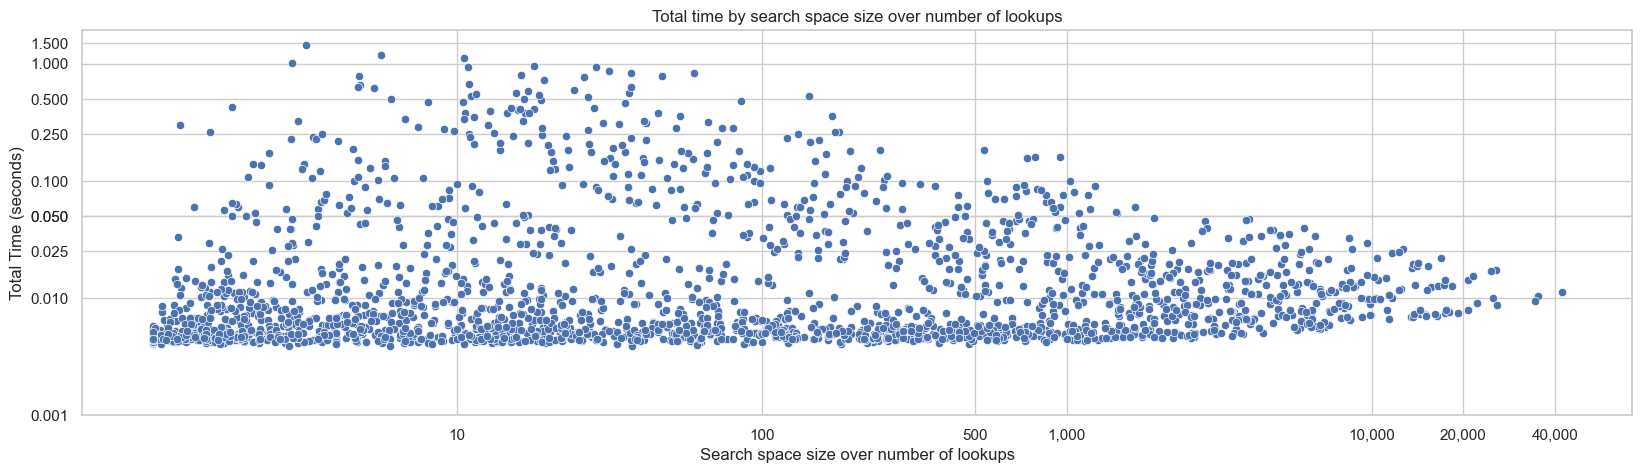

In [120]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

# define the color map

my_plot = sns.scatterplot(data=w_time_df, x="n_ss_ls_ratio_log", y="total_time_log",                          
                         marker='o')

y_ticks = [0.001, .05, .01, .025, .05, .1, .25, .5, 1, 1.5]
y_ticks_log = [np.log10(yt) for yt in y_ticks]
y_tick_labels_formatted = ['{:.3f}'.format(ytl) for ytl in y_ticks]   


x_ticks = [10, 100, 500, 1000, 10000, 20000, 40000]
x_ticks_log = [np.log10(xt) for xt in x_ticks]
print(x_ticks)
x_tick_labels_formatted = ['{:,}'.format(xtl) for xtl in x_ticks]   

my_plot.set_yticks(ticks = y_ticks_log)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_plot.set_xticks(ticks = x_ticks_log)
my_plot.set_xticklabels(labels = x_tick_labels_formatted, rotation=0)

plt.title(label = "Total time by search space size over number of lookups")
plt.xlabel(xlabel = 'Search space size over number of lookups')
plt.ylabel(ylabel = "Total Time (seconds)")
output_file_name = '..\\graphics\\test_graphic_total_time_by_search_space_size_over_number_of_lookups.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [121]:
w_time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time,ls_n_chars,n_ss_ls_ratio,n_ss_ls_ratio_log,total_time_log
5,5,15662,0.008635,bae,2,"[1, 0, 4]",0.004318,3,7831.000000,3.893817,-2.063733
6,6,13453,0.011343,bai,6,"[1, 0, 8]",0.001891,3,2242.166667,3.350668,-1.945264
7,7,7893,0.009343,bca,7,"[1, 2, 0]",0.001335,3,1127.571429,3.052144,-2.029514
8,8,6966,0.006483,bci,2,"[1, 2, 8]",0.003241,3,3483.000000,3.541953,-2.188231
9,9,6039,0.251832,bcl,553,"[1, 2, 11]",0.000455,3,10.920434,1.038240,-0.598889


In [122]:
w_time_df['avg_lookup_time'].describe()

count    2250.000000
mean        0.001413
std         0.001728
min         0.000033
25%         0.000161
50%         0.000678
75%         0.002039
max         0.011353
Name: avg_lookup_time, dtype: float64

In [123]:
w_time_df['n_search_space'].describe()

count     2250.000000
mean      5548.027556
std       8718.750394
min          1.000000
25%        287.250000
50%       1437.500000
75%       7020.250000
max      51206.000000
Name: n_search_space, dtype: float64

In [125]:
w_time_df['n_search_space_log'] = np.log10(w_time_df['n_search_space'])
w_time_df['avg_lookup_time_log'] = np.log10(w_time_df['avg_lookup_time'])

[10, 100, 500, 1000, 10000, 20000, 50000]
..\graphics\test_graphic_total_time_by_search_space_size_over_number_of_lookups.png


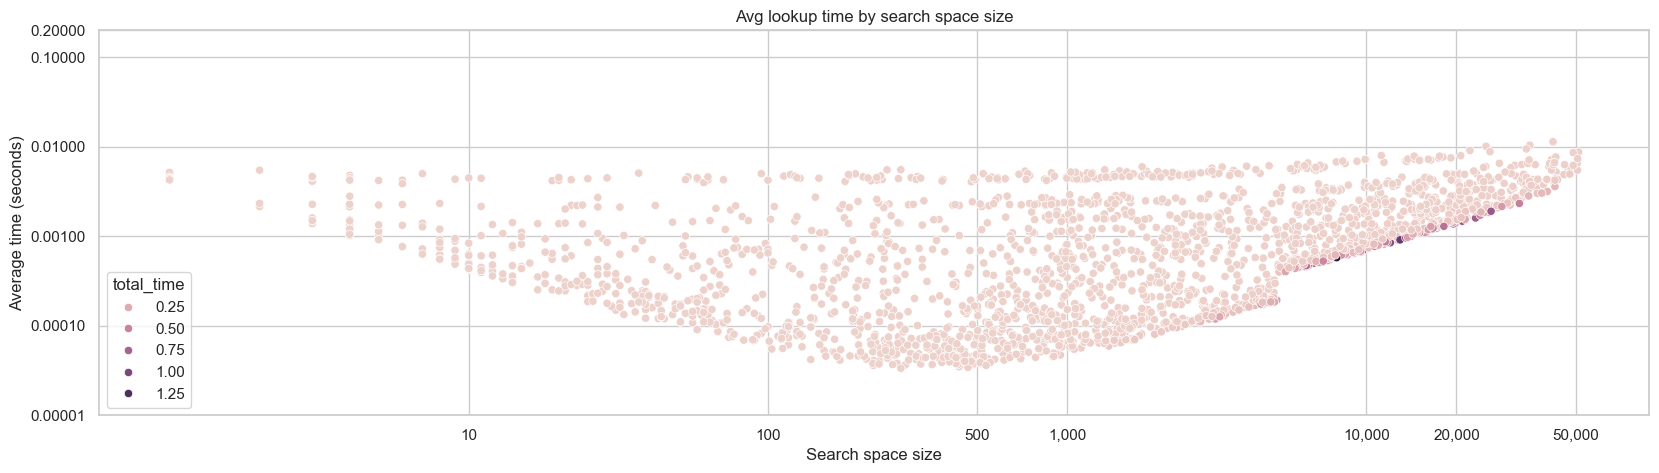

In [128]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

# define the color map

my_plot = sns.scatterplot(data=w_time_df, x="n_search_space_log", y="avg_lookup_time_log",
                          hue='total_time',
                         marker='o')

y_ticks = [0.00001, .0001, .001, .01, .1, .2]
y_ticks_log = [np.log10(yt) for yt in y_ticks]
y_tick_labels_formatted = ['{:.5f}'.format(ytl) for ytl in y_ticks]   


x_ticks = [10, 100, 500, 1000, 10000, 20000, 50000]
x_ticks_log = [np.log10(xt) for xt in x_ticks]
print(x_ticks)
x_tick_labels_formatted = ['{:,}'.format(xtl) for xtl in x_ticks]   

my_plot.set_yticks(ticks = y_ticks_log)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_plot.set_xticks(ticks = x_ticks_log)
my_plot.set_xticklabels(labels = x_tick_labels_formatted, rotation=0)

plt.title(label = "Avg lookup time by search space size")
plt.xlabel(xlabel = 'Search space size')
plt.ylabel(ylabel = "Average time (seconds)")
output_file_name = '..\\graphics\\test_graphic_total_time_by_search_space_size_over_number_of_lookups.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [139]:
w_time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time,ls_n_chars,n_ss_ls_ratio,n_ss_ls_ratio_log,total_time_log,n_search_space_log,avg_lookup_time_log,n_ss_ls_count,total_comps,total_comps_log
5,5,15662,0.008635,bae,2,"[1, 0, 4]",0.004318,3,7831.000000,3.893817,-2.063733,4.194847,-2.364763,31324,31324,4.495877
6,6,13453,0.011343,bai,6,"[1, 0, 8]",0.001891,3,2242.166667,3.350668,-1.945264,4.128819,-2.723416,80718,80718,4.906970
7,7,7893,0.009343,bca,7,"[1, 2, 0]",0.001335,3,1127.571429,3.052144,-2.029514,3.897242,-2.874612,55251,55251,4.742340
8,8,6966,0.006483,bci,2,"[1, 2, 8]",0.003241,3,3483.000000,3.541953,-2.188231,3.842983,-2.489261,13932,13932,4.144013
9,9,6039,0.251832,bcl,553,"[1, 2, 11]",0.000455,3,10.920434,1.038240,-0.598889,3.780965,-3.341614,3339567,3339567,6.523690


..\graphics\test_graphic_total_time_by_total_comps.png


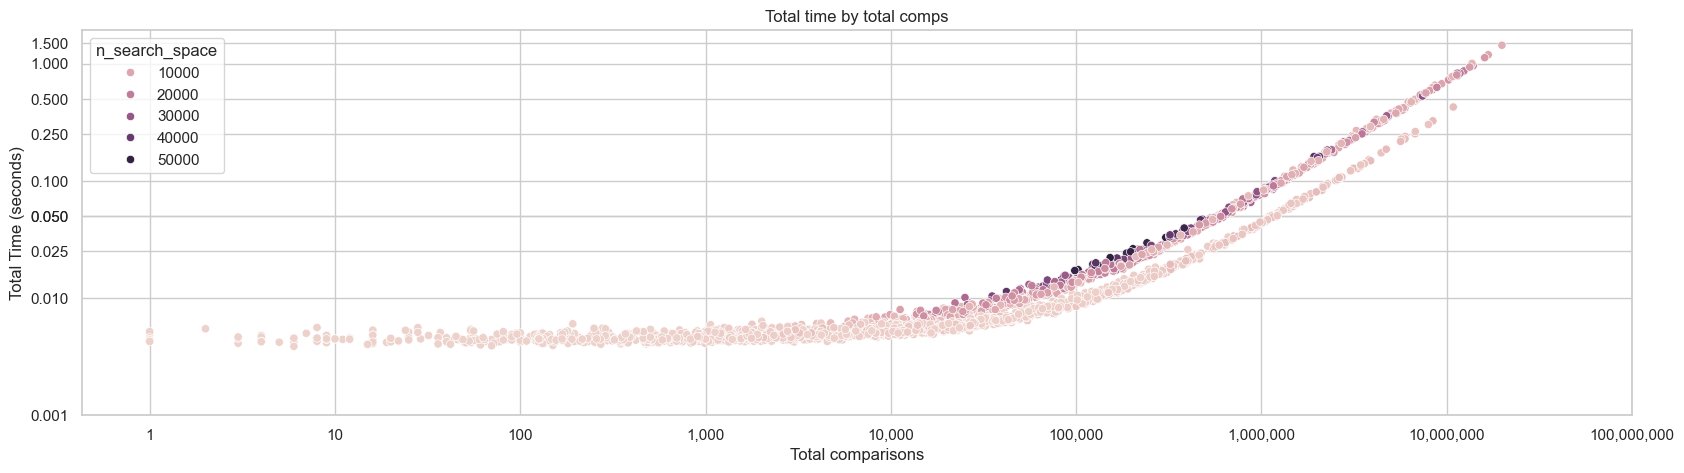

In [ ]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

# define the color map

my_plot = sns.scatterplot(data=w_time_df, x="total_comps_log", y="total_time_log",  
                          hue='n_search_space', size = 
                         marker='o')

y_ticks = [0.001, .05, .01, .025, .05, .1, .25, .5, 1, 1.5]
y_ticks_log = [np.log10(yt) for yt in y_ticks]
y_tick_labels_formatted = ['{:.3f}'.format(ytl) for ytl in y_ticks]   


x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]
x_ticks_log = [10 ** xt for xt in x_ticks]
x_tick_labels_formatted = ['{:,}'.format(xtl) for xtl in x_ticks_log]   

my_plot.set_yticks(ticks = y_ticks_log)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_labels_formatted, rotation=0)

plt.title(label = "Total time by total comps")
plt.xlabel(xlabel = 'Total comparisons')
plt.ylabel(ylabel = "Total Time (seconds)")
output_file_name = '..\\graphics\\test_graphic_total_time_by_total_comps.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [149]:
# let's try to keep the total comps to less than 30K
w_time_df.loc[w_time_df['total_comps'] < 30000, 'total_time'].describe()

count    1125.000000
mean        0.005176
std         0.000874
min         0.003864
25%         0.004542
50%         0.004969
75%         0.005537
max         0.010103
Name: total_time, dtype: float64

In [151]:
wg_df.head()

,word,lcase,n_chars,first_letter,word_id,word_group_id,letter_group,letter_group_ranked,word_group_count,letter_selector,letter_selector_id,n_records
0,A,a,1,a,0,0,a,a,1,a,0,1
1,aa,aa,2,a,1,1,a,a,1,a,0,1
2,aal,aal,3,a,2,2,al,la,2,la,1081,1
3,aalii,aalii,5,a,3,3,ail,lai,1,lai,1083,1
4,aam,aam,3,a,4,4,am,ma,2,ma,1114,1


In [150]:
ls_df.shape

(2387, 4)

In [195]:
wg_df['n_chars'].describe()

count    215842.000000
mean          9.816945
std           2.856492
min           1.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          24.000000
Name: n_chars, dtype: float64

In [ ]:
n_char_split_dict = []

In [180]:
# UPDATE THE SELECTORS
# let's split the matrix, gather the values for each split, and then combine
n_subset_letters = 4
wg_df["letter_selector"] = wg_df["letter_group_ranked"].str[:n_subset_letters]

letter_selector_list = wg_df["letter_selector"].unique()
letter_selector_list.sort()
letter_selector_id_dict = {ls: i_ls for i_ls, ls in enumerate(letter_selector_list)}

wg_df["letter_selector_id"] = wg_df["letter_selector"].map(letter_selector_id_dict)
# here's the thing: I need to be able to identify on a single matrix the rows that match various conditions.
# I can't step through it and create objects at abandon. 
# so, given our wchar_matrix: what are the rows that match to such and such?
# we can add three columns to track this... 

In [ ]:
# let's get cute and compute splits for all characters!

In [ ]:
sorted(wg_df['letter_group_ranked'].str.len().unique().tolist())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [237]:
col_names = ['letter_selector_temp', 'n_records']
ls_df_list = []
for ls_nchar in range(1, 17):
    wg_df['letter_selector_temp'] = wg_df['letter_group_ranked'].str[:ls_nchar + 1]    
    ls_df = wg_df[col_names].groupby(col_names[:-1]).agg(ls_count = ('n_records', 'sum')).reset_index()    
    ls_df_list.append(ls_df)
    

In [238]:
tot_ls_df = pd.concat(objs=ls_df_list,axis = 0)

In [239]:
tot_ls_df.shape

(1196843, 2)

In [240]:
tot_ls_df.head()

,letter_selector_temp,ls_count
0,a,2
1,ae,1
2,ai,1
3,b,1
4,ba,12


In [241]:
tot_ls_df.head()

,letter_selector_temp,ls_count
0,a,2
1,ae,1
2,ai,1
3,b,1
4,ba,12


In [242]:
tot_ls_df.shape

(1196843, 2)

In [247]:
tot_ls_df = tot_ls_df.drop_duplicates(subset = ['letter_selector_temp', 'ls_count'])

In [248]:
tot_ls_df.shape

(250183, 2)

In [249]:
tot_ls_df.head()

,letter_selector_temp,ls_count
0,a,2
1,ae,1
2,ai,1
3,b,1
4,ba,12


In [250]:
wg_df.head()

,word,lcase,n_chars,first_letter,word_id,word_group_id,letter_group,letter_group_ranked,word_group_count,letter_selector,letter_selector_id,n_records,letter_selector_temp
0,A,a,1,a,0,0,a,a,1,a,0,1,a
1,aa,aa,2,a,1,1,a,a,1,a,0,1,a
2,aal,aal,3,a,2,2,al,la,2,la,4760,1,la
3,aalii,aalii,5,a,3,3,ail,lai,1,lai,4762,1,lai
4,aam,aam,3,a,4,4,am,ma,2,ma,4842,1,ma


In [181]:
col_names = ['letter_selector_id', 'letter_selector', 'n_records']
ls_df = wg_df[col_names].groupby(col_names[:-1]).agg(ls_count = ('n_records', 'sum')).reset_index()
# this is effectively a column selector
ls_df['ls_index'] = ls_df['letter_selector'].map(get_ls_index)

In [182]:
ls_df.shape

(10222, 4)

In [183]:
ls_df.head()

,letter_selector_id,letter_selector,ls_count,ls_index
0,0,a,2,[0]
1,1,ae,1,"[0, 4]"
2,2,ai,1,"[0, 8]"
3,3,b,1,[1]
4,4,ba,4,"[1, 0]"


In [251]:
tot_ls_df['ls_index'] = tot_ls_df['letter_selector_temp'].map(get_ls_index)

In [252]:
tot_ls_df.head()

,letter_selector_temp,ls_count,ls_index
0,a,2,[0]
1,ae,1,"[0, 4]"
2,ai,1,"[0, 8]"
3,b,1,[1]
4,ba,12,"[1, 0]"


In [262]:
tot_ls_df = tot_ls_df.reset_index(drop=True)

In [263]:
tot_ls_df.shape

(250183, 3)

In [264]:
tot_ls_df.index

RangeIndex(start=0, stop=250183, step=1)

In [265]:
n_search_space_list = []
for ls_row_id, ls_row in tot_ls_df.iloc[:None].iterrows():    
    if ls_row_id % 1000 == 0:
        print(ls_row_id)    
    
    # get letter selector id information    
    ls_id_index = np.array(ls_row['ls_index'])    

    ##
    # BUILD A COLUMN SELECTOR
    ##
    # make sure that only values GTE 0 are selected so that the right number of
    # columns are return.
    #curr_ls_id = ls_id_index[ls_id_index >= 0]
    
    ##
    # SUBSET THE wchar_matrix by column selector
    ##    
    outcome_indices = np.all(wchar_matrix[:, ls_id_index] >= 1, axis=1)
    #print(outcome_indices.sum())
    
    # this is the sub-matrix from which to query
    #ls_wchar_matrix = wchar_matrix[outcome_indices, :]
        
    # this is the list of word group ids that correspond to the word group ids
    # in the ls_wchar_matrix
    #temp_wg_id_list = word_group_id_list[outcome_indices]
    # place into a dictionary to go from wg_id to wg_index. What is the index
    # of wg_id 675?
    # wg_id_dict = {wg_id:wg_index for wg_index, wg_id in enumerate(temp_wg_id_list)}

    # this is the number of word groups that meet certain criteria. 
    # for example, words that feature the letters: 'bro'    
    #n_search_space = temp_wg_id_list.shape[0]
    n_search_space_list.append(outcome_indices.sum())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [266]:
tot_ls_df['n_search_space'] = n_search_space_list

In [268]:
tot_ls_df.head()

,letter_selector_temp,ls_count,ls_index,n_search_space
0,a,2,[0],133001
1,ae,1,"[0, 4]",84952
2,ai,1,"[0, 8]",82414
3,b,1,[1],35319
4,ba,12,"[1, 0]",23469


In [269]:
tot_ls_df.to_csv(path_or_buf='search_space_count.csv', index = False)

In [270]:
# try the above with cupy!
import cupy as cp

In [271]:
wchar_matrix_cp = cp.asarray(a=wchar_matrix)

In [278]:
n_search_space_list = []
for ls_row_id, ls_row in tot_ls_df.iloc[:None].iterrows():    
    if ls_row_id % 1000 == 0:
        print(ls_row_id)    
    
    # get letter selector id information    
    ls_id_index = cp.asarray(ls_row['ls_index'])    

    ##
    # BUILD A COLUMN SELECTOR
    ##
    # make sure that only values GTE 0 are selected so that the right number of
    # columns are return.
    #curr_ls_id = ls_id_index[ls_id_index >= 0]
    
    ##
    # SUBSET THE wchar_matrix by column selector
    ##    
    outcome_indices = cp.all(wchar_matrix_cp[:, ls_id_index] >= 1, axis=1)
    #print(outcome_indices.sum())
    
    # this is the sub-matrix from which to query
    #ls_wchar_matrix = wchar_matrix[outcome_indices, :]
        
    # this is the list of word group ids that correspond to the word group ids
    # in the ls_wchar_matrix
    #temp_wg_id_list = word_group_id_list[outcome_indices]
    # place into a dictionary to go from wg_id to wg_index. What is the index
    # of wg_id 675?
    # wg_id_dict = {wg_id:wg_index for wg_index, wg_id in enumerate(temp_wg_id_list)}

    # this is the number of word groups that meet certain criteria. 
    # for example, words that feature the letters: 'bro'    
    #n_search_space = temp_wg_id_list.shape[0]
    n_search_space_list.append(outcome_indices.sum())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [185]:
w_time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_index,avg_lookup_time,ls_n_chars,n_ss_ls_ratio,n_ss_ls_ratio_log,total_time_log,n_search_space_log,avg_lookup_time_log,n_ss_ls_count,total_comps,total_comps_log
5,5,15662,0.008635,bae,2,"[1, 0, 4]",0.004318,3,7831.000000,3.893817,-2.063733,4.194847,-2.364763,31324,31324,4.495877
6,6,13453,0.011343,bai,6,"[1, 0, 8]",0.001891,3,2242.166667,3.350668,-1.945264,4.128819,-2.723416,80718,80718,4.906970
7,7,7893,0.009343,bca,7,"[1, 2, 0]",0.001335,3,1127.571429,3.052144,-2.029514,3.897242,-2.874612,55251,55251,4.742340
8,8,6966,0.006483,bci,2,"[1, 2, 8]",0.003241,3,3483.000000,3.541953,-2.188231,3.842983,-2.489261,13932,13932,4.144013
9,9,6039,0.251832,bcl,553,"[1, 2, 11]",0.000455,3,10.920434,1.038240,-0.598889,3.780965,-3.341614,3339567,3339567,6.523690


In [186]:
ls_df['n_search_space'] = n_search_space_list

In [191]:
ls_df.head()


,letter_selector_id,letter_selector,ls_count,ls_index,n_search_space,ls_n_chars,total_comps
0,0,a,2,[0],133001,1,266002
1,1,ae,1,"[0, 4]",84952,2,84952
2,2,ai,1,"[0, 8]",82414,2,82414
3,3,b,1,[1],35319,1,35319
4,4,ba,4,"[1, 0]",23469,2,93876


In [188]:
ls_df['ls_n_chars'] = ls_df['letter_selector'].str.len()

In [189]:
ls_df['ls_n_chars'].value_counts()

ls_n_chars
4    9180
3     905
2     111
1      26
Name: count, dtype: int64

In [190]:
ls_df['total_comps'] = ls_df['ls_count'] * ls_df['n_search_space']

In [194]:
ls_df.loc[ls_df['ls_n_chars'] >= 3, 'total_comps'].describe()

count    1.008500e+04
mean     5.635986e+04
std      2.279326e+05
min      1.000000e+00
25%      3.770000e+02
50%      2.950000e+03
75%      2.242000e+04
max      4.656960e+06
Name: total_comps, dtype: float64